In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

from astroduet.config import Telescope
from astroduet.bbmag import bb_abmag_fluence, bb_abmag
from astroduet.image_utils import construct_image, find, run_daophot, ap_phot, estimate_background
from astroduet.background import background_pixel_rate
from astroduet.duet_telescope import load_telescope_parameters
from astroduet.diff_image import py_zogy

# Set up telescope parameters
duet = Telescope()

# Define image simulation parameters
exposure = 300 * u.s
frame = np.array((18,18)) # Dimensions of the image I'm simulating in DUET pixels (18x18 ~ 2x2 arcmin)
n_exp = 8 # Number of exposures for a reference image

# Calculate sky background
[sky_rate1, sky_rate2] = background_pixel_rate(duet, low_zodi = True, diag=True)
print("Sky background rate: {}, {}".format(sky_rate1,sky_rate2))

# Background galaxy
galaxy = 'spiral'
gal_params = None

-----
Background Computation Integrating over Pixel Area
Telescope diameter: 26.0 cm
Transmission Efficiency: 0.8166518036622619


Pixel Size: 6.4 arcsec
Pixel Area: 40.96000000000001 arcsec2

Zodi Level: 77
Band1 Rate: 0.030369732491096913 ph / s
Band2 Rate: 0.2478588509265617 ph / s
-----
Sky background rate: 0.030369732491096913 ph / s, 0.2478588509265617 ph / s


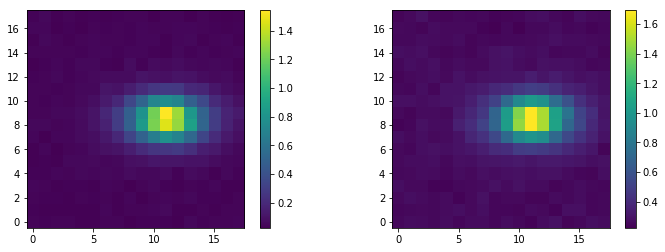

In [2]:
# Simulate reference images, without source, 5 exposures
# Currently a perfect co-add
ref_image1 = construct_image(frame, exposure, \
                            gal_type=galaxy, sky_rate=sky_rate1, n_exp=n_exp)
ref_image_rate1 = ref_image1 / (n_exp * exposure.value)

ref_image2 = construct_image(frame, exposure, \
                            gal_type=galaxy, sky_rate=sky_rate2, n_exp=n_exp)
ref_image_rate2 = ref_image2 / (n_exp * exposure.value)

plt.figure(figsize=[12,4])
plt.subplot(121)
plt.imshow(ref_image_rate1.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(ref_image_rate2.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

In [3]:
# Really simple fading blackbody simulation
bbtemp = 20000 * u.K
swiftmags = np.arange(18,23,0.1) * u.ABmag

bb_rates1, bb_rates2 = np.zeros(len(swiftmags)) * u.ph / u.s, np.zeros(len(swiftmags)) * u.ph / u.s

for i, mag in enumerate(swiftmags):
    fluence1, fluence2 = bb_abmag_fluence(bbtemp=bbtemp, swiftmag=mag, duet=duet)
    bb_rates1[i] = duet.fluence_to_rate(fluence1)
    bb_rates2[i] = duet.fluence_to_rate(fluence2)

In [4]:
psf_fwhm_pix = duet.psf_fwhm / duet.pixel

# Make a 2D array containing the PSF
psf_array = duet.psf_model(x_size=5, y_size=5).array

# Initialise plotting arrays
measured_bb_rate1_psf = np.zeros(len(swiftmags))
measured_bb_rate2_psf = np.zeros(len(swiftmags))
measured_bb_rate_err1_psf = np.zeros(len(swiftmags))
measured_bb_rate_err2_psf = np.zeros(len(swiftmags))

measured_bb_rate1_ap = np.zeros(len(swiftmags))
measured_bb_rate2_ap = np.zeros(len(swiftmags))
measured_bb_rate_err1_ap = np.zeros(len(swiftmags))
measured_bb_rate_err2_ap = np.zeros(len(swiftmags))

for i, rate in enumerate(bb_rates1):
    # Construct the simulated image
    image = construct_image(frame, exposure,
                            gal_type=galaxy, gal_params=gal_params, 
                            source=rate, sky_rate=sky_rate1, duet=duet)
    image_rate = image / exposure.value
    
    # Estimate background
    image_bkg, image_bkg_rms_median = estimate_background(image_rate, method='1D', sigma=2)
    ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate1, method='1D', sigma=2)
    image_rate_bkgsub, ref_rate_bkgsub = image_rate - image_bkg, ref_image_rate1 - ref_bkg
    
    # Generate difference image
    s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate1)
    sn, sr = np.mean(s_n), np.mean(s_r)
    dx, dy = 1,1
    diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,ref_rate_bkgsub.value,
                                        psf_array,psf_array,
                                        s_n.value,s_r.value,sn.value,sr.value,dx,dy)
    diff_image *= image_rate.unit
    
    # Run find
    star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='peaks',background='1D')
    
    # Is peak successfully found? If so, go to photometry
    sep = np.sqrt((star_tbl['x'] - (frame[0]//2))**2 + (star_tbl['y'] - (frame[0]//2))**2)
    if len(sep) > 0:
        closest = np.argmin(sep)
        if np.amin(sep) <= 2:
            sn = Table(rows=star_tbl[closest], names=star_tbl.columns)

            # Perform aperture photometry
            result_ap, apertures, annulus_apertures = ap_phot(diff_image,sn,duet.read_noise,exposure)

            measured_bb_rate1_ap[i] = result_ap['aper_sum_bkgsub'].value
            measured_bb_rate_err1_ap[i] = result_ap['aperture_sum_err'].value

            # Run PSF-fitting photometry
            result_psf, residual_image = run_daophot(diff_image,threshold,sn,niters=1,duet=duet)
            measured_bb_rate1_psf[i] = result_psf['flux_fit']
            measured_bb_rate_err1_psf[i] = result_psf['flux_unc']
            
print("Part 1 done")
        
for i, rate in enumerate(bb_rates2):
    # Construct the simulated image
    image = construct_image(frame, exposure, 
                            gal_type=galaxy, gal_params=gal_params, 
                            source=rate, sky_rate=sky_rate2, duet=duet)
    image_rate = image / exposure.value
    
    # Estimate background
    image_bkg, image_bkg_rms_median = estimate_background(image_rate, method='1D', sigma=2)
    ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate2, method='1D', sigma=2)
    image_rate_bkgsub, ref_rate_bkgsub = image_rate - image_bkg, ref_image_rate2 - ref_bkg
    
    # Generate difference image
    s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate2)
    sn, sr = np.mean(s_n), np.mean(s_r)
    dx, dy = 1,1
    diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,ref_rate_bkgsub.value,
                                        psf_array,psf_array,
                                        s_n.value,s_r.value,sn.value,sr.value,dx,dy)
    diff_image *= image_rate.unit
    
    # Run find
    star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='peaks',background='1D')
    
    # Is peak successfully found? If so, go to photometry
    sep = np.sqrt((star_tbl['x'] - (frame[0]//2))**2 + (star_tbl['y'] - (frame[0]//2))**2)
    if len(sep) > 0:
        closest = np.argmin(sep)
        if np.amin(sep) <= 2:
            sn = Table(rows=star_tbl[closest], names=star_tbl.columns)
        
            # Perform aperture photometry
            result_ap, apertures, annulus_apertures = ap_phot(diff_image,sn,duet.read_noise,exposure)     
            measured_bb_rate2_ap[i] = result_ap['aper_sum_bkgsub'].value
            measured_bb_rate_err2_ap[i] = result_ap['aperture_sum_err'].value

            # Run PSF-fitting photometry
            result_psf, residual_image = run_daophot(diff_image,threshold,sn,niters=1,duet=duet)
            measured_bb_rate2_psf[i] = result_psf['flux_fit']
            measured_bb_rate_err2_psf[i] = result_psf['flux_unc']
            
print("Part 2 done")

Part 1 done
Part 2 done


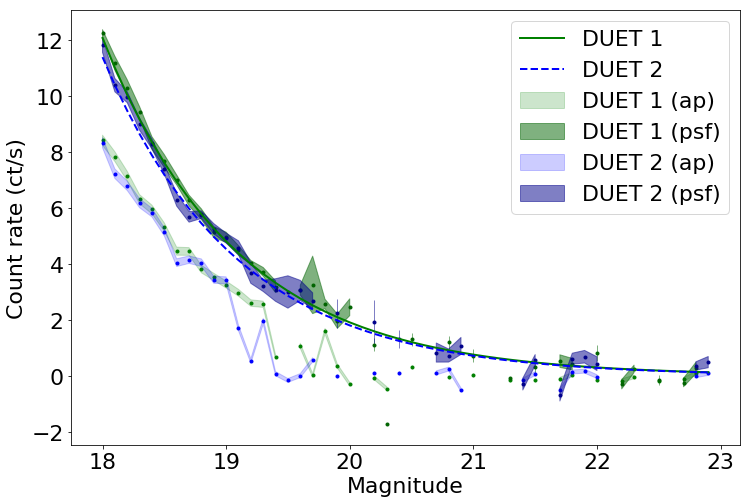

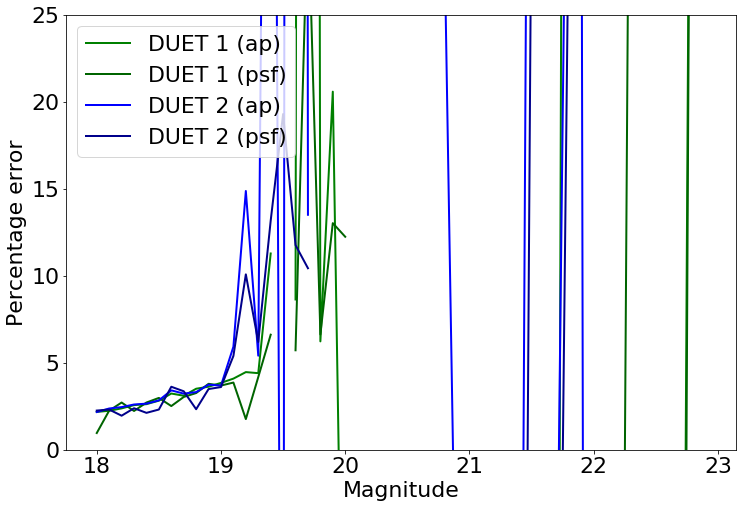

In [5]:
# Change zeros out to nans to prevent plotting
measured_bb_rate1_psf[measured_bb_rate1_psf == 0] = np.nan
measured_bb_rate2_psf[measured_bb_rate2_psf == 0] = np.nan
measured_bb_rate_err1_psf[measured_bb_rate_err1_psf == 0] = np.nan
measured_bb_rate_err2_psf[measured_bb_rate_err2_psf == 0] = np.nan

measured_bb_rate1_ap[measured_bb_rate1_ap == 0] = np.nan
measured_bb_rate2_ap[measured_bb_rate2_ap == 0] = np.nan
measured_bb_rate_err1_ap[measured_bb_rate_err1_ap == 0] = np.nan
measured_bb_rate_err2_ap[measured_bb_rate_err2_ap == 0] = np.nan

# Now plot the stuff
font = {'size': 22}
matplotlib.rc('font', **font)

plt.figure(figsize=[12,8])
#plt.semilogy()
plt.xlabel('Magnitude')
plt.ylabel('Count rate (ct/s)')

# Plot actual count ratea
plt.plot(swiftmags,bb_rates1,linewidth=2,color='g', label='DUET 1')
plt.plot(swiftmags,bb_rates2,linewidth=2,color='b',linestyle='--', label='DUET 2')

# Plot measured count ratea
plt.scatter(swiftmags, measured_bb_rate1_ap, color='green', marker='.')
plt.fill_between(swiftmags, measured_bb_rate1_ap - measured_bb_rate_err1_ap, \
                 measured_bb_rate1_ap + measured_bb_rate_err1_ap, \
                 color='green', alpha=0.2, label='DUET 1 (ap)')
plt.scatter(swiftmags, measured_bb_rate1_psf, color='darkgreen', marker='.')
plt.fill_between(swiftmags, measured_bb_rate1_psf - measured_bb_rate_err1_psf, \
                 measured_bb_rate1_psf + measured_bb_rate_err1_psf, \
                 color='darkgreen', alpha=0.5, label='DUET 1 (psf)')

plt.scatter(swiftmags, measured_bb_rate2_ap, color='b', marker='.')
plt.fill_between(swiftmags, measured_bb_rate2_ap - measured_bb_rate_err2_ap, \
                 measured_bb_rate2_ap + measured_bb_rate_err2_ap, \
                 color='blue', alpha=0.2, label='DUET 2 (ap)')
plt.scatter(swiftmags, measured_bb_rate2_psf, color='darkblue', marker='.')
plt.fill_between(swiftmags, measured_bb_rate2_psf - measured_bb_rate_err2_psf, \
                 measured_bb_rate2_psf + measured_bb_rate_err2_psf, \
                 color='darkblue', alpha=0.5, label='DUET 2 (psf)')
plt.legend()


plt.figure(figsize=[12,8])
plt.xlabel('Magnitude')
plt.ylabel('Percentage error')
plt.plot(swiftmags,measured_bb_rate_err1_ap/measured_bb_rate1_ap*100,color='green',lw=2,label='DUET 1 (ap)')
plt.plot(swiftmags,measured_bb_rate_err1_psf/measured_bb_rate1_psf*100,color='darkgreen',lw=2,label='DUET 1 (psf)')
plt.plot(swiftmags,measured_bb_rate_err2_ap/measured_bb_rate2_ap*100,color='blue',lw=2,label='DUET 2 (ap)')
plt.plot(swiftmags,measured_bb_rate_err2_psf/measured_bb_rate2_psf*100,color='darkblue',lw=2,label='DUET 2 (psf)')
plt.ylim(0,25)
plt.legend()

In [6]:
import os
datadir = os.path.join(os.getcwd(), '../astroduet/data')

# Load up SNIIp light curves
# Red supergiant shock breakout @ 100 Mpc

dist = 100 * u.Mpc
lightcurve_file = fits.open(datadir+'/SNIIp_lightcurve_DUET.fits')
lc = lightcurve_file[1].data
lightcurve_file.close()

# Fluence given at 10pc - convert to 100 Mpc
time = lc['Time'] * u.s
dist0 = 10 * u.pc
src_fluence1 = lc['photflux_D1'] * u.ph*(dist0.to(u.pc)/dist.to(u.pc))**2 / (u.cm**2 * u.s)
src_fluence2 = lc['photflux_D2'] * u.ph*(dist0.to(u.pc)/dist.to(u.pc))**2 / (u.cm**2 * u.s)

src_mag1 = lc['mag_D1']
src_mag2 = lc['mag_D2']

In [8]:
# Source lightcurve loop

# Caluculate rates
src_rate1 = duet.fluence_to_rate(src_fluence1)
src_rate2 = duet.fluence_to_rate(src_fluence2)

# Initialise plotting arrays
measured_src_rate1_psf = np.zeros(len(time))
measured_src_rate2_psf = np.zeros(len(time))
measured_src_rate_err1_psf = np.zeros(len(time))
measured_src_rate_err2_psf = np.zeros(len(time))

measured_src_rate1_ap = np.zeros(len(time))
measured_src_rate2_ap = np.zeros(len(time))
measured_src_rate_err1_ap = np.zeros(len(time))
measured_src_rate_err2_ap = np.zeros(len(time))

# Possibly introduce Matteo's sampling routine here
for i, rate in enumerate(src_rate1):
    # Construct the simulated image
    image = construct_image(frame, exposure,
                            gal_type=galaxy, gal_params=gal_params, 
                            source=rate, sky_rate=sky_rate1, duet=duet)
    image_rate = image / exposure.value
    
    # Estimate background
    image_bkg, image_bkg_rms_median = estimate_background(image_rate, method='1D', sigma=2)
    ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate1, method='1D', sigma=2)
    image_rate_bkgsub, ref_rate_bkgsub = image_rate - image_bkg, ref_image_rate1 - ref_bkg
    
    # Generate difference image
    s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate1)
    sn, sr = np.mean(s_n), np.mean(s_r)
    dx, dy = 1,1
    diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,ref_rate_bkgsub.value,
                                        psf_array,psf_array,
                                        s_n.value,s_r.value,sn.value,sr.value,dx,dy)
    diff_image *= image_rate.unit
    
    # Run find
    star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='peaks',background='1D')
    
    # Is peak successfully found? If so, go to photometry
    sep = np.sqrt((star_tbl['x'] - (frame[0]//2))**2 + (star_tbl['y'] - (frame[0]//2))**2)
    if len(sep) > 0:
        closest = np.argmin(sep)
        if np.amin(sep) <= 2:
            sn = Table(rows=star_tbl[closest], names=star_tbl.columns)
        
            # Perform aperture photometry
            result_ap, apertures, annulus_apertures = ap_phot(diff_image,sn,duet.read_noise,exposure)
            measured_src_rate1_ap[i] = result_ap['aper_sum_bkgsub'].value
            measured_src_rate_err1_ap[i] = result_ap['aperture_sum_err'].value

            # Run PSF-fitting photometry
            result_psf, residual_image = run_daophot(diff_image,threshold,sn,niters=1,duet=duet)
            measured_src_rate1_psf[i] = result_psf['flux_fit']
            measured_src_rate_err1_psf[i] = result_psf['flux_unc']
        
for i, rate in enumerate(src_rate2):
    # Construct the simulated image
    image = construct_image(frame, exposure, 
                            gal_type=galaxy, gal_params=gal_params, 
                            source=rate, sky_rate=sky_rate2, duet=duet)
    image_rate = image / exposure.value
    
    # Estimate background
    image_bkg, image_bkg_rms_median = estimate_background(image_rate, method='1D', sigma=2)
    ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate2, method='1D', sigma=2)
    image_rate_bkgsub, ref_rate_bkgsub = image_rate - image_bkg, ref_image_rate2 - ref_bkg
    
    # Generate difference image
    s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate2)
    sn, sr = np.mean(s_n), np.mean(s_r)
    dx, dy = 1,1
    diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,ref_rate_bkgsub.value,
                                        psf_array,psf_array,
                                        s_n.value,s_r.value,sn.value,sr.value,dx,dy)
    diff_image *= image_rate.unit
    
    # Run find
    star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='peaks',background='1D')
    
    # Is peak successfully found? If so, go to photometry
    sep = np.sqrt((star_tbl['x'] - (frame[0]//2))**2 + (star_tbl['y'] - (frame[0]//2))**2)
    if len(sep) > 0:
        closest = np.argmin(sep)
        if np.amin(sep) <= 2:
            sn = Table(rows=star_tbl[closest], names=star_tbl.columns)
        
            # Perform aperture photometry
            result_ap, apertures, annulus_apertures = ap_phot(diff_image,sn,duet.read_noise,exposure)
            measured_src_rate2_ap[i] = result_ap['aper_sum_bkgsub'].value
            measured_src_rate_err2_ap[i] = result_ap['aperture_sum_err'].value

            # Run PSF-fitting photometry
            result_psf, residual_image = run_daophot(diff_image,threshold,sn,niters=1,duet=duet)
            measured_src_rate2_psf[i] = result_psf['flux_fit']
            measured_src_rate_err2_psf[i] = result_psf['flux_unc']
        

(0, 30)

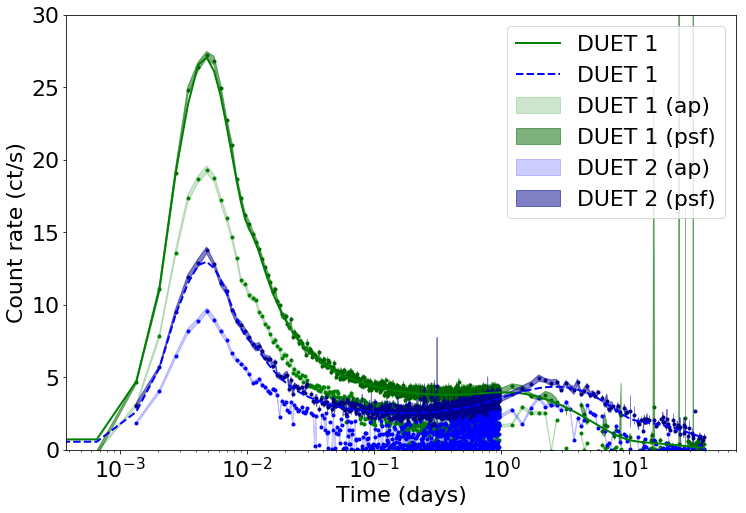

In [9]:
# Change zeros out to nans to prevent plotting
measured_src_rate1_psf[measured_src_rate1_psf == 0] = np.nan
measured_src_rate2_psf[measured_src_rate2_psf == 0] = np.nan
measured_src_rate_err1_psf[measured_src_rate_err1_psf == 0] = np.nan
measured_src_rate_err2_psf[measured_src_rate_err2_psf == 0] = np.nan

measured_src_rate1_ap[measured_src_rate1_ap == 0] = np.nan
measured_src_rate2_ap[measured_src_rate2_ap == 0] = np.nan
measured_src_rate_err1_ap[measured_src_rate_err1_ap == 0] = np.nan
measured_src_rate_err2_ap[measured_src_rate_err2_ap == 0] = np.nan

# Now plot the stuff
font = {'size': 22}
matplotlib.rc('font', **font)

plt.figure(figsize=[12,8])
plt.semilogx()
plt.xlabel('Time (days)')
time_axis = (time-time[0]-3000*u.s).to(u.day) # -3000? (Taken from SNe Lightcurve notebook)

plt.ylabel('Count rate (ct/s)')

# Plot actual count ratea
plt.plot(time_axis,src_rate1,linewidth=2,color='g',label='DUET 1')
plt.plot(time_axis,src_rate2,linewidth=2,color='b',linestyle='--',label='DUET 1')

# Plot measured count ratea
plt.scatter(time_axis, measured_src_rate1_ap, color='g', marker='.')
plt.fill_between(time_axis, measured_src_rate1_ap - measured_src_rate_err1_ap, \
                 measured_src_rate1_ap + measured_src_rate_err1_ap, \
                 color='green', alpha=0.2, label='DUET 1 (ap)')
plt.scatter(time_axis, measured_src_rate1_psf, color='darkgreen', marker='.')
plt.fill_between(time_axis, measured_src_rate1_psf - measured_src_rate_err1_psf, \
                 measured_src_rate1_psf + measured_src_rate_err1_psf, \
                 color='darkgreen', alpha=0.5, label='DUET 1 (psf)')

plt.scatter(time_axis, measured_src_rate2_ap, color='b', marker='.')
plt.fill_between(time_axis, measured_src_rate2_ap - measured_src_rate_err2_ap, \
                 measured_src_rate2_ap + measured_src_rate_err2_ap, \
                 color='blue', alpha=0.2, label='DUET 2 (ap)')
plt.scatter(time_axis, measured_src_rate2_psf, color='darkblue', marker='.')
plt.fill_between(time_axis, measured_src_rate2_psf - measured_src_rate_err2_psf, \
                 measured_src_rate2_psf + measured_src_rate_err2_psf, \
                 color='darkblue', alpha=0.5, label='DUET 2 (psf)')

plt.legend()
plt.ylim(0,30)

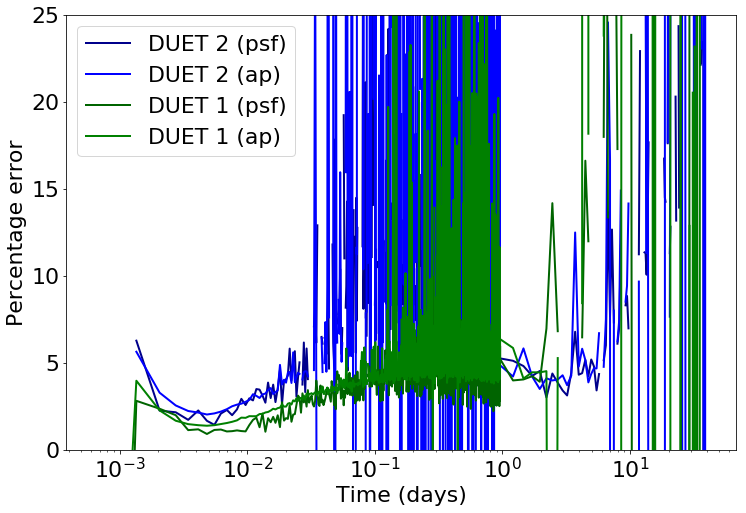

In [10]:
plt.figure(figsize=[12,8])
plt.semilogx()
plt.xlabel('Time (days)')
plt.ylabel('Percentage error')
plt.plot(time_axis,measured_src_rate_err2_psf/measured_src_rate2_psf*100,color='darkblue',lw=2,label='DUET 2 (psf)')
plt.plot(time_axis,measured_src_rate_err2_ap/measured_src_rate2_ap*100,color='blue',lw=2,label='DUET 2 (ap)')
plt.plot(time_axis,measured_src_rate_err1_psf/measured_src_rate1_psf*100,color='darkgreen',lw=2,label='DUET 1 (psf)')
plt.plot(time_axis,measured_src_rate_err1_ap/measured_src_rate1_ap*100,color='green',lw=2,label='DUET 1 (ap)')
plt.ylim(0,25)
plt.legend()

(0, 100)

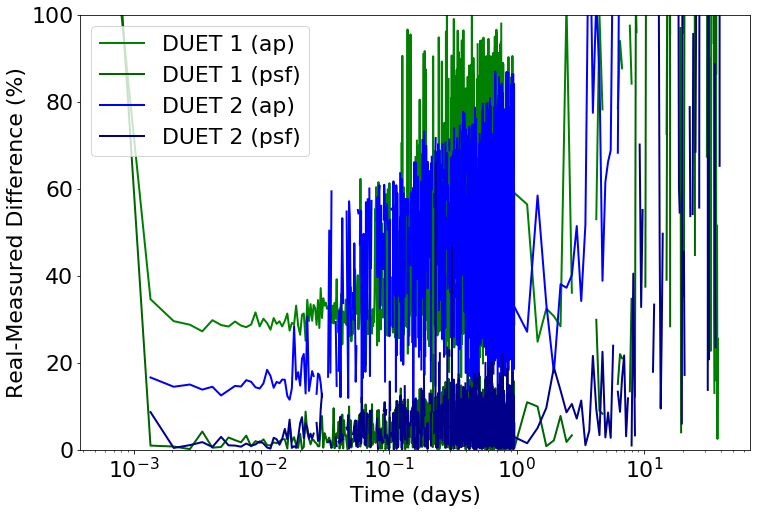

In [11]:
plt.figure(figsize=[12,8])
plt.semilogx()
plt.xlabel('Time (days)')
plt.ylabel('Real-Measured Difference (%)')
plt.plot(time_axis,np.abs(src_rate1.value-measured_src_rate1_ap)/src_rate1.value*100,color='green',lw=2,label='DUET 1 (ap)')
plt.plot(time_axis,np.abs(src_rate1.value-measured_src_rate1_psf)/src_rate1.value*100,color='darkgreen',lw=2,label='DUET 1 (psf)')
plt.plot(time_axis,np.abs(src_rate2.value-measured_src_rate2_ap)/src_rate1.value*100,color='blue',lw=2,label='DUET 2 (ap)')
plt.plot(time_axis,np.abs(src_rate2.value-measured_src_rate2_psf)/src_rate1.value*100,color='darkblue',lw=2,label='DUET 2 (psf)')
plt.legend()
plt.ylim(0,100)

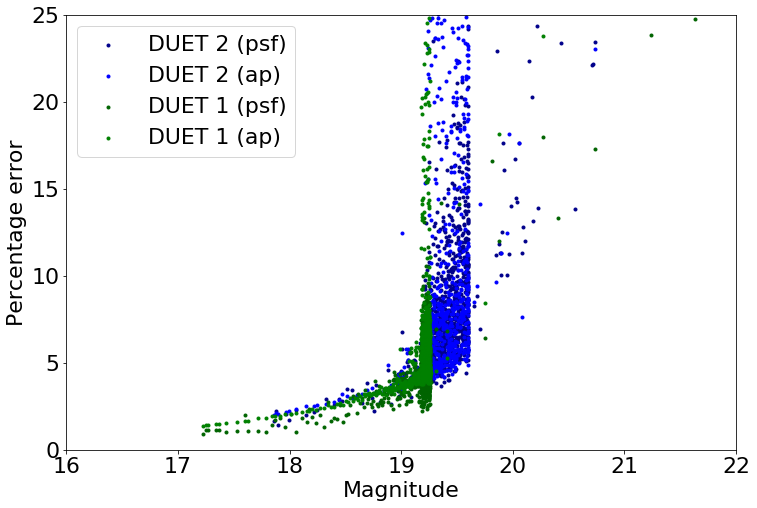

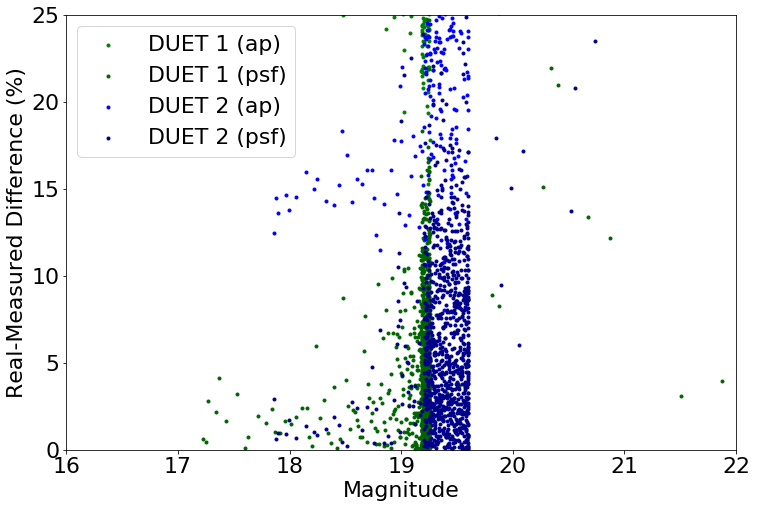

In [14]:
dist_mod = 35

plt.figure(figsize=[12,8])
plt.xlabel('Magnitude')
plt.ylabel('Percentage error')
plt.scatter(src_mag2+dist_mod,measured_src_rate_err2_psf/measured_src_rate2_psf*100,color='darkblue',marker='.',label='DUET 2 (psf)')
plt.scatter(src_mag2+dist_mod,measured_src_rate_err2_ap/measured_src_rate2_ap*100,color='blue',marker='.',label='DUET 2 (ap)')
plt.scatter(src_mag1+dist_mod,measured_src_rate_err1_psf/measured_src_rate1_psf*100,color='darkgreen',marker='.',label='DUET 1 (psf)')
plt.scatter(src_mag1+dist_mod,measured_src_rate_err1_ap/measured_src_rate1_ap*100,color='green',marker='.',label='DUET 1 (ap)')
plt.ylim(0,25)
plt.xlim(16,22)
plt.legend()

plt.figure(figsize=[12,8])
plt.xlabel('Magnitude')
plt.ylabel('Real-Measured Difference (%)')
plt.scatter(src_mag1+dist_mod,np.abs(src_rate1.value-measured_src_rate1_ap)/src_rate1.value*100,color='green',marker='.',label='DUET 1 (ap)')
plt.scatter(src_mag1+dist_mod,np.abs(src_rate1.value-measured_src_rate1_psf)/src_rate1.value*100,color='darkgreen',marker='.',label='DUET 1 (psf)')
plt.scatter(src_mag2+dist_mod,np.abs(src_rate2.value-measured_src_rate2_ap)/src_rate1.value*100,color='blue',marker='.',label='DUET 2 (ap)')
plt.scatter(src_mag2+dist_mod,np.abs(src_rate2.value-measured_src_rate2_psf)/src_rate1.value*100,color='darkblue',marker='.',label='DUET 2 (psf)')
plt.xlim(16,22)
plt.ylim(0,25)
plt.legend()